# Sydney Forecast

## 0. Introduction

We have collected, using the **NASA website**, data of the average, maximum and minimum **temperatures in Sydney over the last decade** (see details in `get_data.py`). Our main mission will be to create a model capable of making a **forecast with at least 80% accuracy** to predict the weather in one to two years.

First of all, let's load the main packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Data initial exploration

In [2]:
import json

path = './Data/POWER_Point_Daily_20140928_20240927_033d88S_151d21E_LST.json'

with open (path, 'r') as Sydney:
    diccionario = json.load(Sydney)

In [3]:
data = diccionario['properties']['parameter']

# We convert to dataframe:
df = pd.DataFrame({
    'date': pd.to_datetime(list(data['T2M'].keys())),  # we convert to datatime format
    'average_temperature': list(data['T2M'].values()),
    'max_temperature': list(data['T2M_MAX'].values()),
    'min_temperature': list(data['T2M_MIN'].values())
})

df.head()


,date,average_temperature,max_temperature,min_temperature
0,2014-09-28,17.39,21.55,13.04
1,2014-09-29,20.97,27.51,15.47
2,2014-09-30,21.45,26.39,15.87
3,2014-10-01,16.80,21.05,14.80
4,2014-10-02,16.94,21.45,12.72


We now have a look at the main parameters of our data:

In [4]:
print(df.describe())
print('')
print(df.info())

                      date  average_temperature  max_temperature  \
count                 3653          3653.000000      3653.000000   
mean   2019-09-28 00:00:00            17.457848        20.180851   
min    2014-09-28 00:00:00          -999.000000      -999.000000   
25%    2017-03-29 00:00:00            15.820000        18.260000   
50%    2019-09-28 00:00:00            18.930000        21.410000   
75%    2022-03-29 00:00:00            21.720000        24.350000   
max    2024-09-27 00:00:00            30.080000        39.850000   
std                    NaN            37.806273        37.959659   

       min_temperature  
count      3653.000000  
mean         15.083301  
min        -999.000000  
25%          13.420000  
50%          16.550000  
75%          19.590000  
max          25.330000  
std          37.725375  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype        

We have a really strange values for the min value, so let's make a quick plot of the data, so we can see some wrong or missing fields:

## 2. Data cleaning

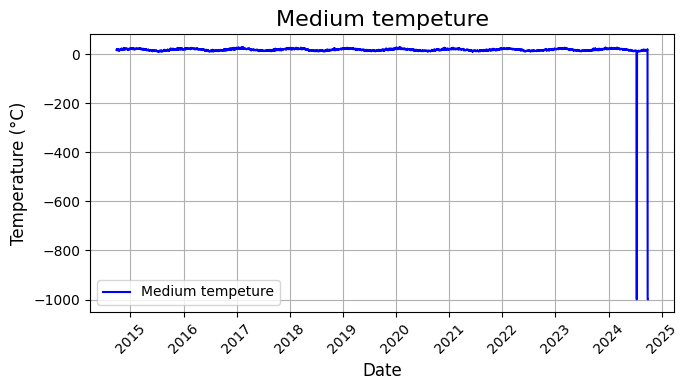

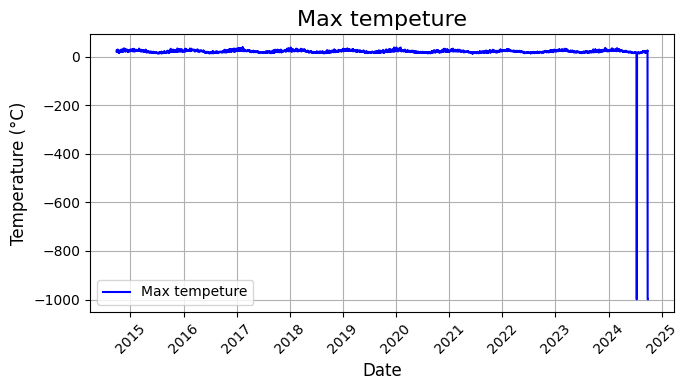

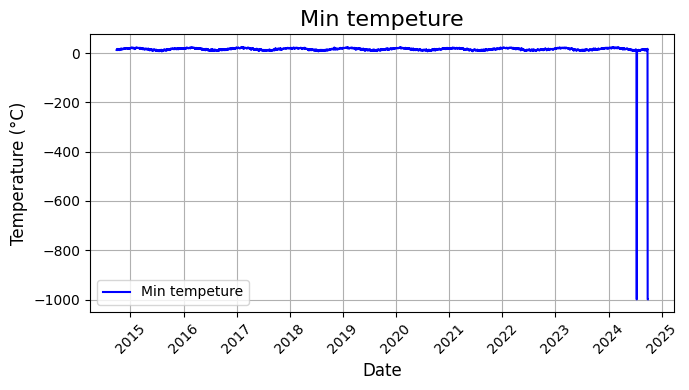

In [5]:
names = ['Medium tempeture', 'Max tempeture', 'Min tempeture']


for feature,name  in zip(df.columns[1:4], names): 
    plt.figure(figsize=(7, 4))
    plt.plot(df['date'], df[feature], label=name, color='b')
    plt.title(name, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()


We can observe there is something wrong with some data. Let's clean it:

In [6]:
df.isnull().sum() #there are no null values

date                   0
average_temperature    0
max_temperature        0
min_temperature        0
dtype: int64

In [7]:
for feature in df.columns[1:4]:
    small_values = (df[feature] < -20).sum()
    print(f'There are {small_values} in {feature}')
 #there are 5 really small values 

There are 5 in average_temperature
There are 5 in max_temperature
There are 5 in min_temperature


In [8]:
df.loc[df['average_temperature'] < -20]

,date,average_temperature,max_temperature,min_temperature
3575,2024-07-12,-999.0,-999.0,-999.0
3576,2024-07-13,-999.0,-999.0,-999.0
3577,2024-07-14,-999.0,-999.0,-999.0
3651,2024-09-26,-999.0,-999.0,-999.0
3652,2024-09-27,-999.0,-999.0,-999.0


We have found the wrong values, let's drop them and plot the data again:

In [9]:
wrong_index = df.loc[df['average_temperature'] < -20].index
print(len(df))
df.drop(wrong_index, inplace = True)
print(len(df))

3653
3648


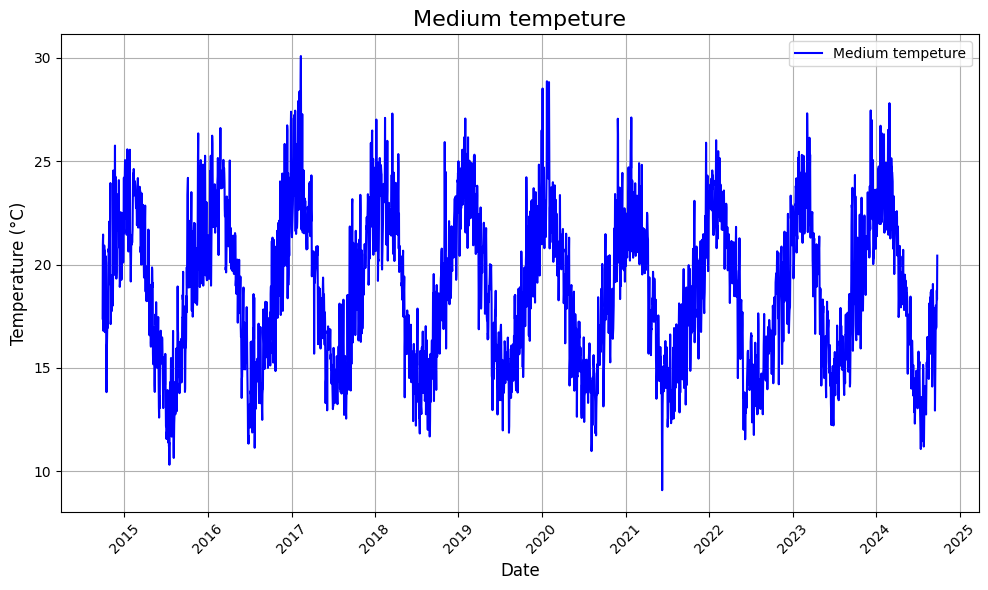

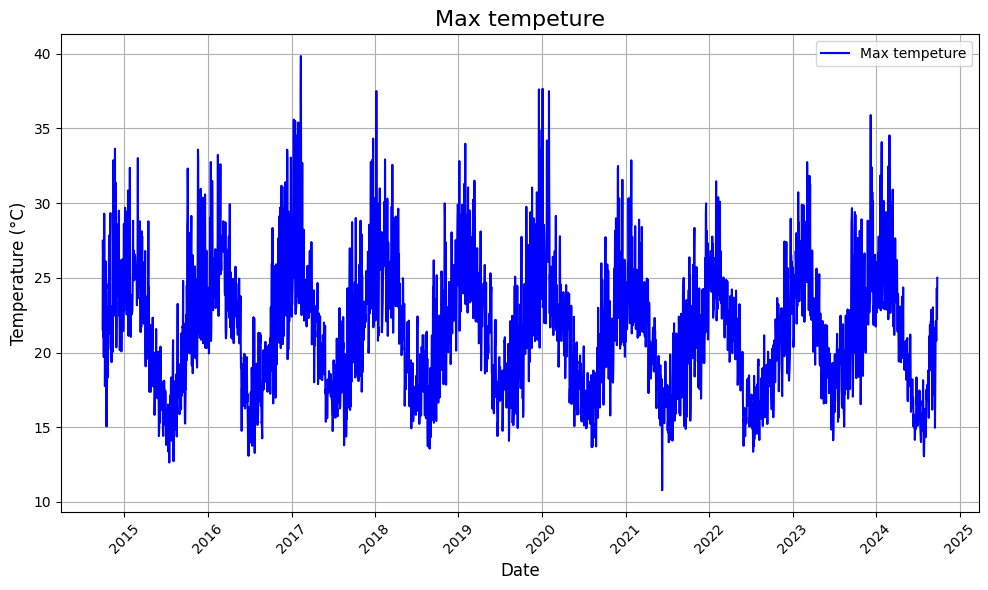

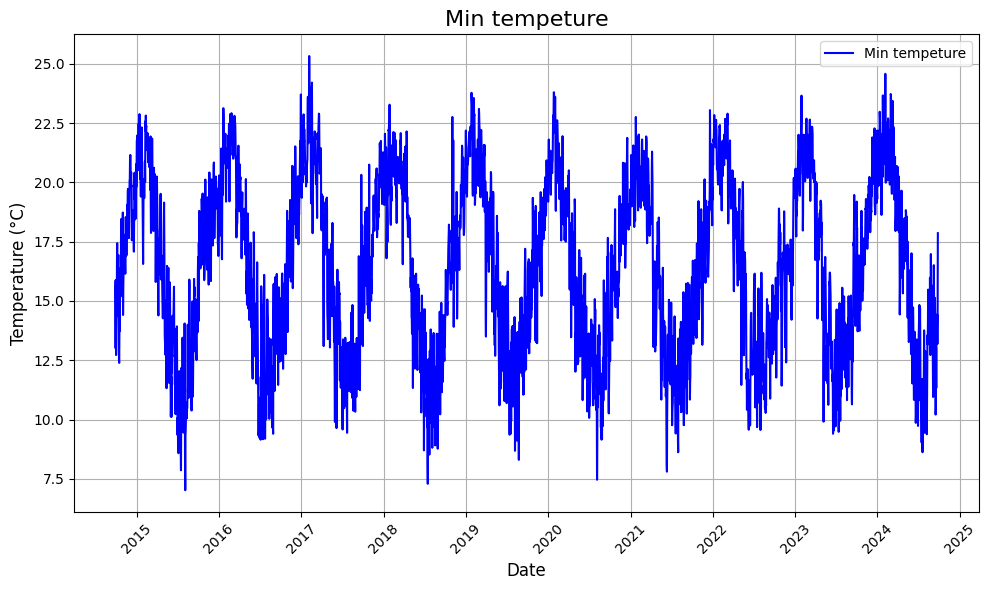

In [10]:
for feature,name  in zip(df.columns[1:], names): 
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df[feature], label=name, color='b')
    plt.title(name, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

To make the problem easier, **we are working just with the average_temperature**:

In [11]:
df.drop(['max_temperature', 'min_temperature'], axis = 1, inplace = True)
df.head()

,date,average_temperature
0,2014-09-28,17.39
1,2014-09-29,20.97
2,2014-09-30,21.45
3,2014-10-01,16.80
4,2014-10-02,16.94


## 3. Regression models

Our first models attempts will be using **Linear Regression and SVR**. As we are only using one feature and the time series has a strong seasonal component, we expect these models not work really well. We are going to add some new features to enhance the data:

#### Feature engineering

We are adding, for each sample, the corresponding year, month and day. With this, we are capturing the periodic character of the data, especially with the 'month' parameter:

In [12]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

Let's add also the temperature the same day last year and let's work from the second year onwards:

In [13]:
df['av_temp_lastyear'] = df['average_temperature'].shift(365)
#df.drop(0, inplace = True)
df[365:].head()
df2 = df[365:]

Now we create **X (features matrix)** and **y (target vector)**:

In [14]:
X = df2.drop(['average_temperature','date'], axis = 1)
y = df2.average_temperature

In [15]:
from sklearn.model_selection import train_test_split


A common mistake now is to use:

```python
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
```
The reason is we want to predict the forecast from a given moment and this function mix the data.  We should concrete shuffle = False:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, shuffle = False)

### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [19]:
y_prediction = linear_reg.predict(X_test)

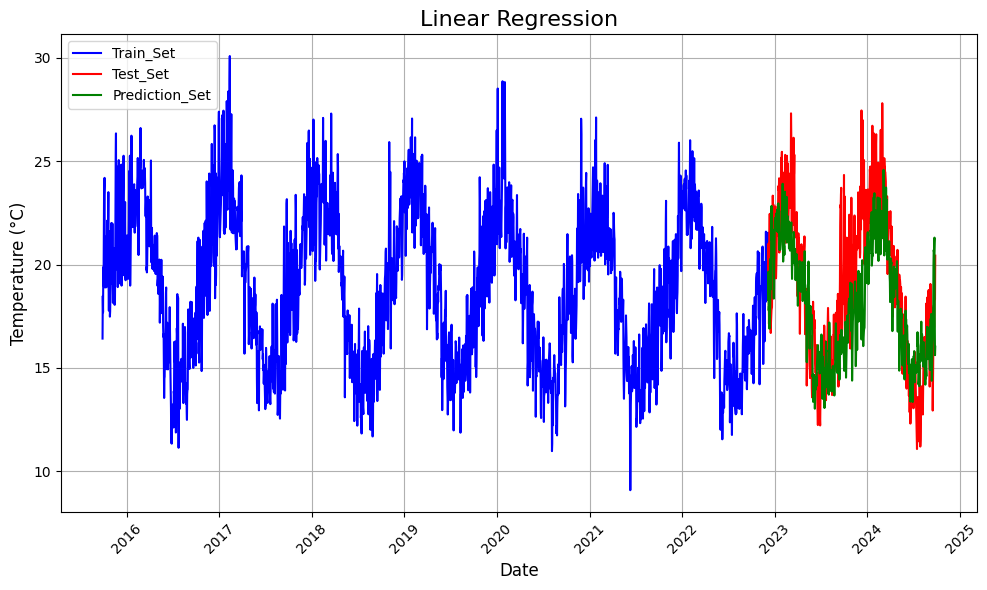

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(df2['date'][0:len(y_train)], y_train, label='Train_Set', color='b')
plt.plot(df2['date'][len(y_train):], y_test, label='Test_Set', color = 'r')
plt.plot(df2['date'][len(y_train):], y_prediction, label='Prediction_Set', color = 'g')
plt.title('Linear Regression', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [21]:
linear_reg.score(X_test,y_test)

0.5136354133676522

We can observe the model is capturing the periodical behaviour because we have added the new features.  Anyway, it is not a good model, as expected.

### SVR

Let's now have a look at how SVR perfom in our data:

In [22]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

#### Default settings

First we will try with **default settings**:

In [23]:
svr_default = SVR()
svr_default.fit(X_train, y_train)

SVR()

In [24]:
y_pred_default = svr_default.predict(X_test)

In [25]:
mse_default = mean_squared_error(y_test, y_pred_default)
r2_default = r2_score(y_test, y_pred_default)
print(f"MSE default param.: {mse_default:.4f}")
print(f"R² default param.: {r2_default:.4f}")

MSE default param.: 13.0505
R² default param.: 0.0069


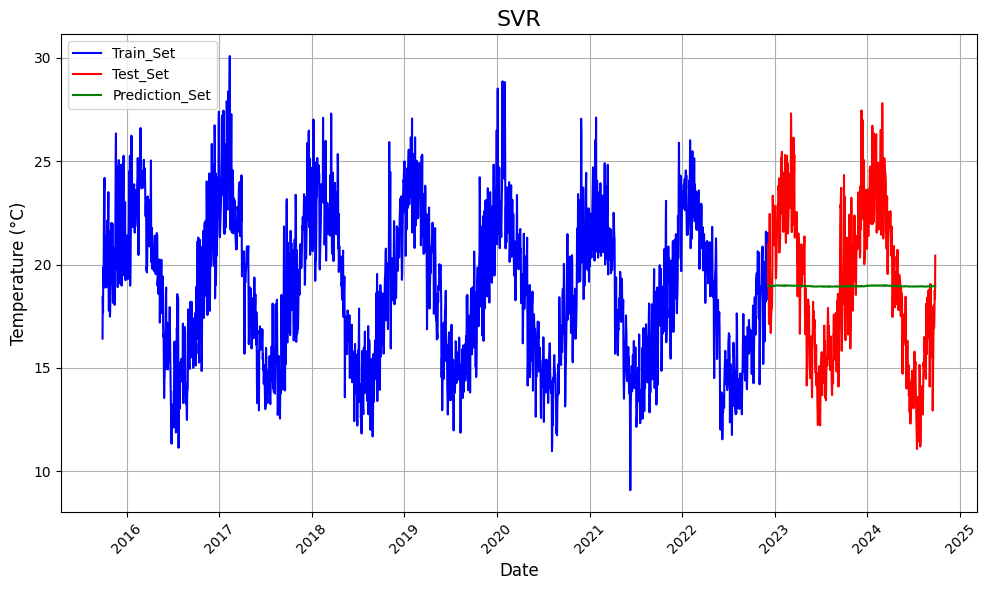

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(df2['date'][0:len(y_train)], y_train, label='Train_Set', color='b')
plt.plot(df2['date'][len(y_train):], y_test, label='Test_Set', color = 'r')
plt.plot(df2['date'][len(y_train):], y_pred_default, label='Prediction_Set', color = 'g')
plt.title('SVR', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

The model is not working properly. Let's make some modifications:

#### Best parameters

First, scale the data:

In [27]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()


X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

Now, find the best model parameters: 

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled)

print(f"Best parameters: {grid_search.best_params_}")


Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [29]:
best_model = grid_search.best_estimator_
best_model

SVR(C=1, gamma='auto')

In [30]:
y_pred_scaled = best_model.predict(X_test_scaled)

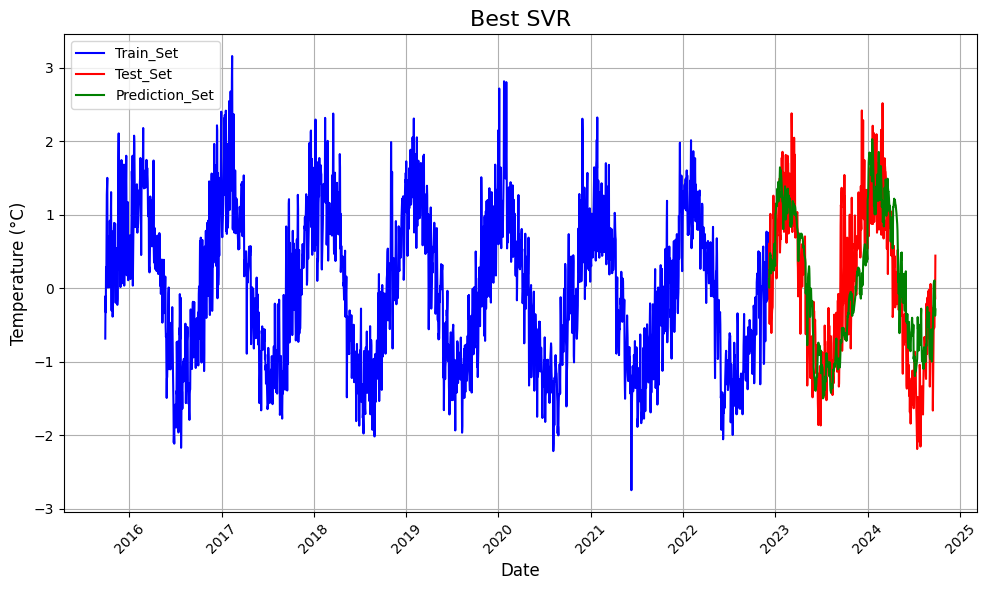

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(df2['date'][0:len(y_train)], y_train_scaled, label='Train_Set', color='b')
plt.plot(df2['date'][len(y_train):], y_test_scaled, label='Test_Set', color = 'r')
plt.plot(df2['date'][len(y_train):], y_pred_scaled, label='Prediction_Set', color = 'g')
plt.title('Best SVR', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

#note that we are ploting the scaled values but we could rescale the data using "scaler_X//scaler_y.inverse_transform(---)"

In [32]:
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"MSE best model: {mse:.4f} and the score is: {best_model.score(X_test_scaled,y_test_scaled)}")

MSE best model: 0.3917 and the score is: 0.623564765001172


Our models are well just because we did a good work job creating additional features, but we can do it better.

## 4. Neural Network

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

We will use Keras (which is part of TensorFlow) to build and train a simple neural network.

In [35]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Input

model = Sequential()

# Definimos explícitamente el Input en lugar de usar input_shape en la primera capa
model.add(Input(shape=(X_train_scaled.shape[1],)))

# Añadimos capas densas
# Primera capa oculta con 64 neuronas y función de activación 'relu'
model.add(Dense(64, activation='relu'))

# Segunda capa oculta con 32 neuronas
model.add(Dense(32, activation='relu'))

# Capa de salida con una sola neurona para regresión (sin activación, regresión)
model.add(Dense(1))

# Compilamos el modelo con el optimizador Adam y la función de pérdida 'mean_squared_error'
model.compile(optimizer='adam', loss='mean_squared_error')

model

<Sequential name=sequential_1, built=True>

In [37]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, verbose=0)

y_pred_scaled = model.predict(X_test_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse = model.evaluate(X_test_scaled, y_test_scaled)

print(f'MSE: {mse}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.3831
MSE: 0.4552847743034363


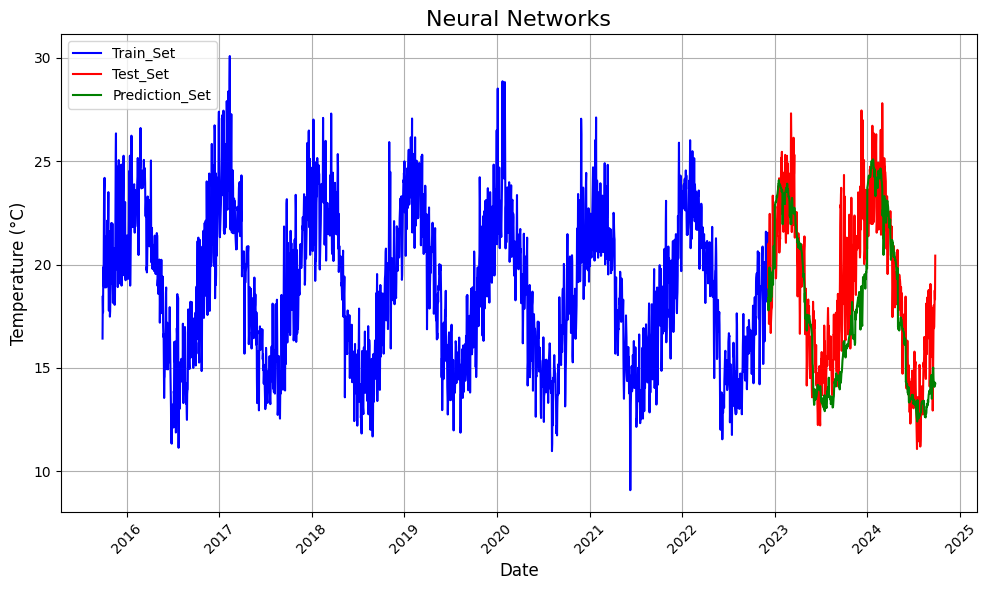

In [38]:
plt.figure(figsize=(10, 6))

plt.plot(df2['date'][0:len(y_train)], y_train, label='Train_Set', color='b')

plt.plot(df2['date'][len(y_train):], y_test, label='Test_Set', color='r')

plt.plot(df2['date'][len(y_train):], y_pred, label='Prediction_Set', color='g')

plt.title('Neural Networks', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [39]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

R-squared (R²): 0.5624556537915996


Getting a terrible result

## 5. Time Series Forecasting model

Despite having worked with our data as a 'Regression problem', we can change the point of view and consider our data as a Time Series and the problem as **Time Series Forecasting**. 

So far we have been developing a model considering the periodic aspect of our data, i.e we have related each data point with the date and, therefore,  with the average temperature obtained on the same day in previous years. Now, we are going to develop a models, known as **ARIMA** and **SARIMA**, that do not require us to input relationships that have to do with periodicity. 

### ARIMA

**ARIMA**, short for AutoRegressive Integrated Moving Average, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values. Arima models are specifed by three order parameters: (p, d, q)


    - AR(p) Autoregression – a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.

$$
\text{AR Model:   } Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \dots + \beta_p Y_{t-p} + \epsilon_t
$$

    - I(d) Integration – uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times.



    - MA(q) Moving Average – a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.


$$
\text{MA Model:   } \\ Y_t = \alpha + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + \dots + \phi_q \epsilon_{t-q}
$$


Hence, ARIMA model is one where the time series was differenced at least once to make it stationary and we combine the AR and the MA terms.

$$
\text{ARIMA Model:   } \\ Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \dots + \beta_p Y_{t-p} + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + \dots + \phi_q \epsilon_{t-q}
$$



### SARIMA Model

**SARIMA** (Seasonal Autoregressive Integrated Moving Average) is an extension of the ARIMA model that also accounts for seasonality in the time series data.

The SARIMA model is defined by the following parameters:
- **AR(p)**.
- **I(d)**.
- **MA(q)**.

The seasonal part of the SARIMA model is defined as:
- **P**: Seasonal autoregressive order.
- **D**: Seasonal differencing to remove seasonality.
- **Q**: Seasonal moving average order.
- **s**: The number of periods in a season (e.g., 12 for monthly data, 4 for quarterly data, 52 for weekly data).

Hence, SARIMA can be represented as:
$$
SARIMA(p, d, q)(P, D, Q)_s
$$

Let's remember how the serie looks like so we can try to forecast some parameters:

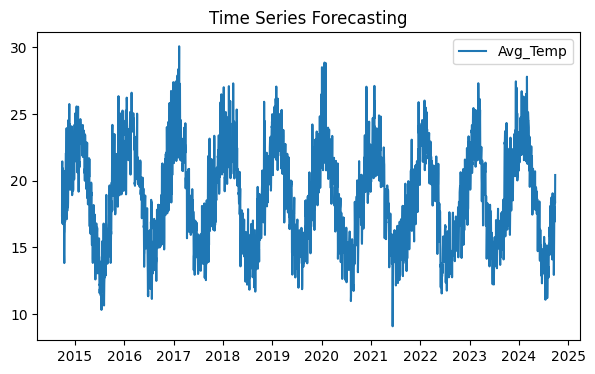

In [41]:
datos = df[['date','average_temperature']]

datos.set_index('date', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(datos, label='Avg_Temp')
ax.set_title('Time Series Forecasting')
ax.legend(loc='best')

First of all, as we already know, we can observe our series has a strong seasonal component, so we might adjust the seasonal differencing properly.
Therefore, a SARIMA model is appropriate.

Another thing we can see is that in terms of regular (non-seasonal) differencing, there doesn’t seem to be a clear long-term growth or decline trend. This indicates that regular differencing (parm d) is not necessary, as the series has no clear trend so we set d=0.

Before continue, as we are working with so many data and my computer can not manage, we are reducing the sample:

In [42]:
datos = datos.resample('W').mean()
datos

,average_temperature
date,
2014-09-28,17.390000
2014-10-05,18.984286
2014-10-12,19.221429
2014-10-19,16.557143
2014-10-26,19.172857
...,...
2024-09-01,17.777143
2024-09-08,16.665714
2024-09-15,16.185714


### Set paramethers manually 

In the study of these models we need two fundamentals concepts:

1. Autocorrelation (ACF): measures the correlation between a time series and a shifted version of itself. In other words, it measures how the value of an observation at one point in time is correlated with the value of the same series at an earlier point in time (lag) (we use it to estimate the MA paramether `q`)


2. Partial Autocorrelation (PACF): measures the correlation between an observation and a shifted version of itself (lag), eliminating the effect of intermediate lags (we use it to estimate the AR paramether `p`)


Let's plot ACF and PACF to obtain more information:

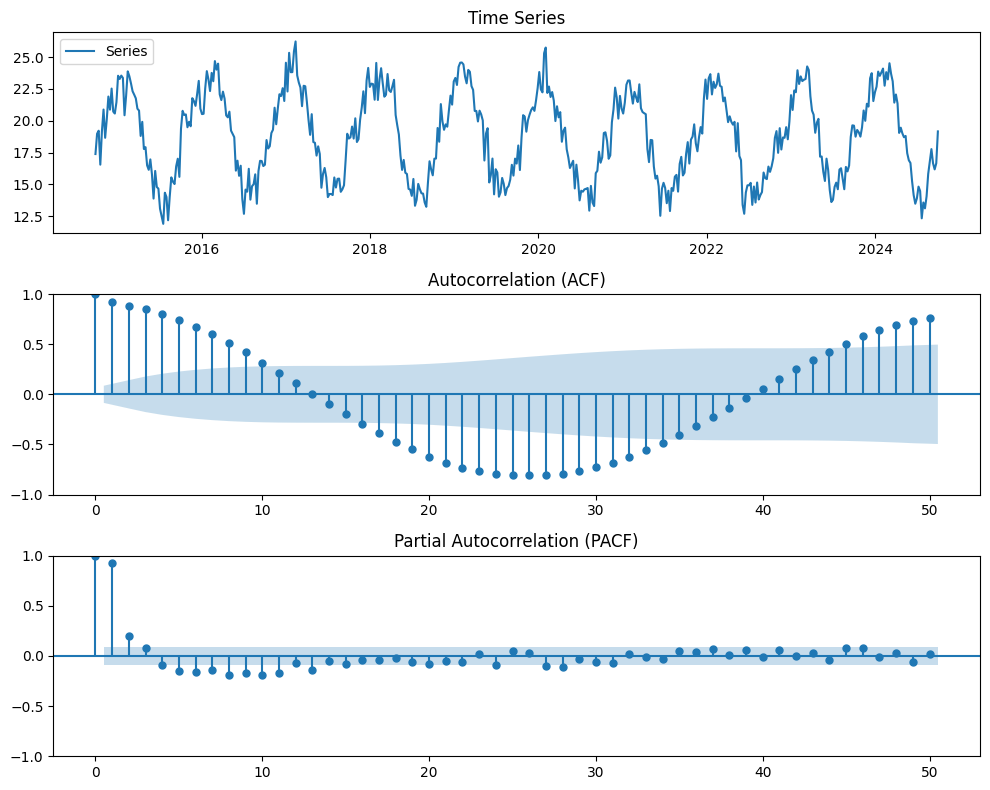

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=50):
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))
    
    # Time series
    axes[0].plot(series, label='Series')
    axes[0].set_title('Time Series')
    axes[0].legend(loc='best')
    
    #  ACF
    plot_acf(series, lags=lags, ax=axes[1])
    axes[1].set_title('Autocorrelation (ACF)')
    
    #  PACF
    plot_pacf(series, lags=lags, ax=axes[2])
    axes[2].set_title('Partial Autocorrelation (PACF)')
    
    plt.tight_layout()
    plt.show()

plot_acf_pacf(datos, lags=50)


The autocorrelation plot of the original serie shows that the values are highly correlated over many lags and it is a clear indicator that the series has strong seasonality because the correlation values agree with the 52-week annual period.

The PACF drops sharply after a significant lag, suggesting that a simple autoregressive (AR) term might be enough to capture the dependency between nearby observations. This implies that a low p value, possibly p = 1, could be sufficient.


To estimate now the capital paramethers of SARIMA, we take the new data **seasonal diff** and we analize the graphics:

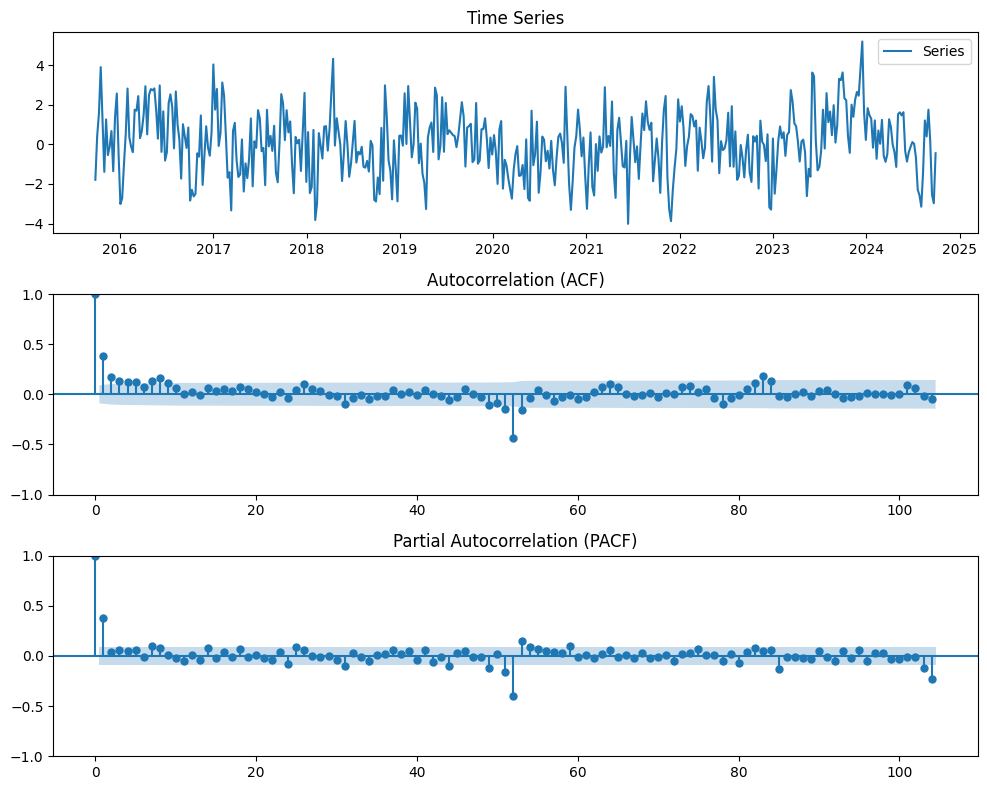

In [44]:
# Diff seasonal
datos_seasonal_diff = datos.diff(52).dropna()

plot_acf_pacf(datos_seasonal_diff, lags=52*2) #two anual periods

The resulting data shows no clear trend, indicating that the seasonal differencing was appropriate. 

The ACF plot exhibits a significant spike at lag 1, suggesting a moving average component, so we can set Q = 1. 

The PACF plot also shows a spike at lag 1, pointing to an autoregressive component P, that we set in 1. 

Now we have estimate all the SARIMA paramethers, we can develop our first model:

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
datos_train, datos_test = train_test_split(datos, test_size= 0.3, shuffle=False)

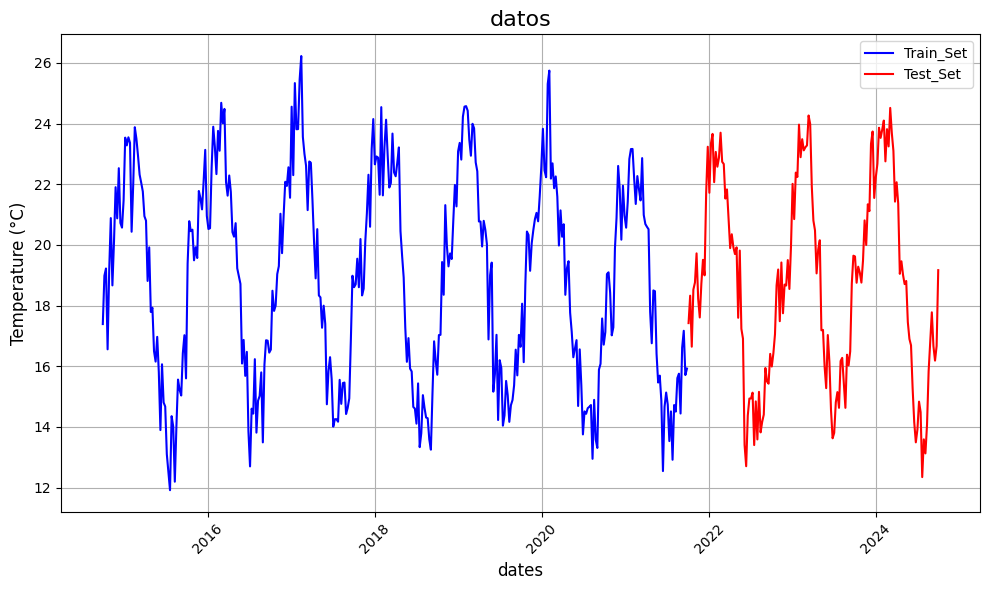

In [46]:
#We can confirm the data is well splited

plt.figure(figsize=(10, 6))
plt.plot(datos_train, label='Train_Set', color='b')
plt.plot(datos_test, label='Test_Set', color = 'r')
plt.title('datos', fontsize=16)
plt.xlabel('dates', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


In [47]:
import statsmodels.api as sm

sarima_model = sm.tsa.SARIMAX(datos_train['average_temperature'], 
                              order=(1, 0, 1), 
                              seasonal_order=(1, 1, 1, 52),
                              enforce_stationarity=False, 
                              enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)

print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                average_temperature   No. Observations:                  366
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -419.275
Date:                            Fri, 04 Oct 2024   AIC                            848.550
Time:                                    21:37:58   BIC                            866.353
Sample:                                09-28-2014   HQIC                           855.707
                                     - 09-26-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7698      0.104      7.372      0.000       0.565       0.974
ma.L1         -0.5618      0.135   

Let's **predict 52 weeks** (one year)

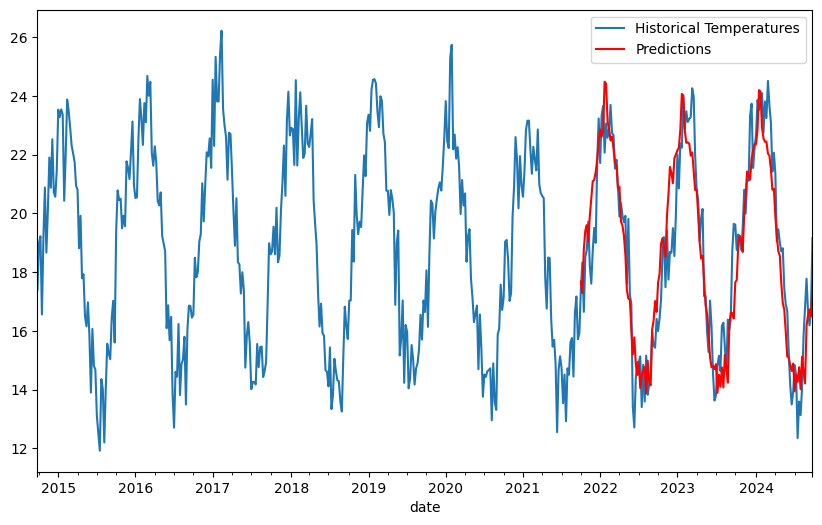

In [51]:
predictions = sarima_fit.get_forecast(steps=len(datos_test))
datos_pred = predictions.predicted_mean 

"""
This is the predicted mean of the distribution of expected values ​​for each future point. Since predictions in SARIMA are probabilistic, 
the predicted value is actually the mean of the distribution of possible future values. This is the value that is typically used as the model's 
point prediction.
"""
datos['average_temperature'].plot(label='Historical Temperatures', figsize=(10, 6))

datos_pred.plot(label='Predictions', color='red')

plt.legend()
plt.show()


In [52]:
r2 = r2_score(datos_test, datos_pred)
print(f'R-squared (R²): {r2}')

R-squared (R²): 0.8405441779202223


#### Auto SARIMA

We could now try to find a better model using several loops:

In [119]:
import statsmodels.api as sm
from sklearn.metrics import r2_score
from joblib import Parallel, delayed


p = [1,2,3]    # Reducido para p
d = [0]    # Reducido para d
q = [1,2,3]    # Reducido para q
P = [0, 1, 2]    # Reducido para P estacional
D = [1]    # Reducido para D estacional
Q = [0, 1, 2]    # Reducido para Q estacional
s = 52        # Periodo estacional (52 semanas)

def fit_sarima_model(i, j, k, I, J, K):
    try:
        # Define el modelo SARIMA
        model = sm.tsa.SARIMAX(datos_train['average_temperature'],
                               order=(i, j, k),
                               seasonal_order=(I, J, K, s),
                               enforce_stationarity=False,
      
                               enforce_invertibility=False)

        results = model.fit(disp=False)
        
        predictions = results.get_forecast(steps=len(datos_test))
        predicted_mean = predictions.predicted_mean
        
        r2 = r2_score(datos_test['average_temperature'], predicted_mean)
        
        return (r2, (i, j, k, I, J, K))
    except:
        return (float('-inf'), None)



results = Parallel(n_jobs=-1)(delayed(fit_sarima_model)(i, j, k, I, J, K) 
                              for i in p for j in d for k in q 
                              for I in P for J in D for K in Q)


valid_results = [result for result in results if result[1] is not None]


best_r2, best_model = max(valid_results, key=lambda x: x[0])


print(f"Best SARIMA: (p,d,q) = {best_model[:3]}, (P,D,Q,52) = {best_model[3:]}")
print(f"Best R^2: {best_r2}")


Mejor modelo ARIMA: (p,d,q) = (2, 0, 1), (P,D,Q,52) = (1, 1, 2)
Mejor R^2: 0.8596200973456275


## 6. Conclusion

Throughout this work we have been able to review various aspects that are common in machine learning projects. From data collection and cleaning to comparing different models to find the one that best fits the data.

We have been able to find a model that exceeded 80% accuracy in its forecast, which implies success.

The performance of the regression models has been poor, mainly due to the non-linearity of the data and the lack of features. On the other hand, the neural network, not having been developed to a very complex one, has not led to very interesting results either.

As a point to improve we could highlight the incorporation of more features based on past records. We could use Fourier series to capture the sinusoidal character of the data and thus the seasonality.

On the other hand, we have been able to study the ARIMA and SARIMA models in quite depth. To obtain a more complete analysis it would be necessary either to optimize the code to be able to include the 3600 days of the original DataFrame or to use a more prepared team to process all that data.

In conclusion, this project has allowed us to explore in depth the typical workflow in the field of machine learning and it has been a perfect exercise to improve my data analysis and prediction skills. 